#### Thickness dependence

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("../../Functions")
from GS_waves import select_freq_range
from abtem.waves import PlaneWave
from Column_matching import (
    inv_Bessel,
    Bessel_transform
    )
from Defocus_circle import generate_continious_phase
import Generate_structure
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from circle_fit import least_squares_circle
from Complex_Gaussian import (
    Gaussian_fitting,
    Gaussian_in_focus,
    Gaussian_function
)
from matplotlib.legend_handler import HandlerTuple

100%|██████████| 48/48 [00:35<00:00,  1.37it/s]


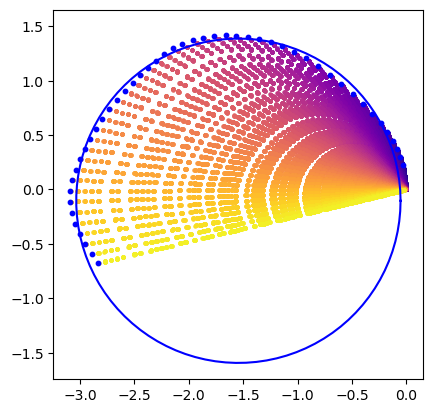

In [61]:
#Parameters to set
gmin = 0; gmax = 2; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50
#Results from isolated column
max_thickness = 50
thickness_range = np.arange(2, max_thickness, 1)
theta = np.linspace(0, 2*np.pi, 100)
cmap = plt.get_cmap("plasma")
slope_rec = []
coeff_rec = []
fitted_rec = []
for thickness in tqdm(thickness_range):
    n_repeat = 3
    structure_1 = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
    exitwave_1 = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure_1).array),
                            gmin, gmax, sampling)
    m, n = exitwave_1.shape
    exitwave_1 = exitwave_1[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                            (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
    results, components = Bessel_transform(exitwave_1-1, sampling, gmin+0.01, gmax, length, x0=sampling/2, y0=sampling/2)
    krange = np.linspace(gmin+0.01, gmax, length)
    #Step 2: fit for Gaussian function
    result = Gaussian_fitting(results,
                              krange,
                              [0.01, 1])
    coeff_rec.append(np.array(list(result.best_values.values())))
    results_fit = result.best_fit
    m, n = components.shape
    a1, a2, b1, b2, c1, c2 = np.array(list(result.best_values.values()))
    #results_fit = Gaussian_function(krange, a1, a2, b1, b2, c1, c2)
    #results_fit = Gaussian_function(krange, a1, a2, b1, b2, c1, c2) - c1 - 1j*c2
    results_fit = Gaussian_in_focus(krange, a1, a2, b1, c1, c2) - c1 - 1j*c2
    #results_fit = results - c1 - 1j*c2
    components_fit = inv_Bessel(results_fit, m, n, sampling, gmin+0.01, gmax, length, x0=sampling/2, y0=sampling/2)
    index = np.unravel_index(np.argmax(np.abs(components_fit)), components_fit.shape)
    peak_fitted = components_fit[index]
    fitted_rec.append(peak_fitted)
    #plt.scatter(np.real(peak_fitted), np.imag(peak_fitted), s=5, color=cmap(thickness/max_thickness))
    plt.scatter(np.real(components_fit), np.imag(components_fit), s=5, color=cmap(thickness/max_thickness))
    #plt.scatter(np.real(results), np.imag(results), color=cmap(thickness/max_thickness), s=5)
    #plt.plot(np.real(results_fit), np.imag(results_fit), color=cmap(thickness/max_thickness), linewidth=1)
slope_rec = np.array(slope_rec)
coeff_rec = np.array(coeff_rec)
fitted_rec = np.array(fitted_rec)
#plt.plot(thickness_range, coeff_rec)
#plt.xlim([0, 0.5])
plt.scatter(np.real(fitted_rec), np.imag(fitted_rec), color='b', s=10)
coordinates_to_fit = np.vstack((np.real(fitted_rec), np.imag(fitted_rec))).T
xc, yc, r, sigma = least_squares_circle(coordinates_to_fit)
plt.plot(xc + r*np.cos(theta), yc + r*np.sin(theta), color='b')
plt.axis("square")
plt.show()

In [32]:
coordinates_to_fit = np.vstack((np.real(fitted_rec), np.imag(fitted_rec))).T
print(coordinates_to_fit.shape)

(78, 2)


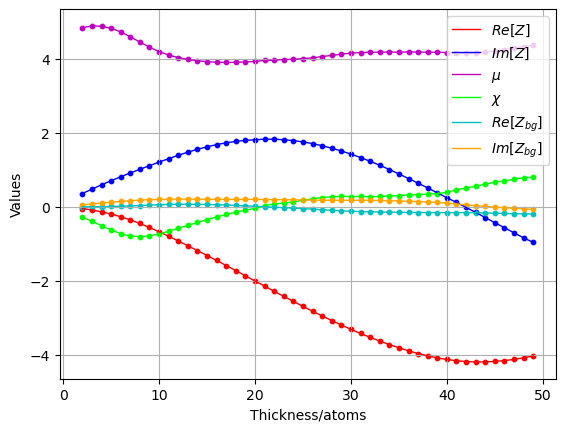

In [68]:
#a_re, a_im, b_re, b_im, c_re, c_im
label_list = [r"$Re[Z]$", r"$Im[Z]$", r"$\mu$", r"$\chi$", r"$Re[Z_{bg}]$", r"$Im[Z_{bg}]$"]
color_list = ["r", "b", "m", "lime", "c", "orange"]
for index in range(6):
    plt.plot(thickness_range, coeff_rec[:,index],
             color=color_list[index],
             label=label_list[index], linewidth=1)
    plt.scatter(thickness_range, coeff_rec[:,index],
             color=color_list[index], s=10)
plt.legend()
plt.xlabel("Thickness/atoms")
plt.ylabel("Values")
plt.grid()
plt.show()

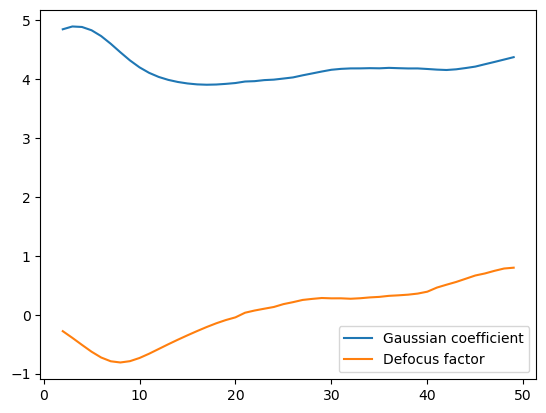

In [37]:
plt.plot(thickness_range, coeff_rec[:,2], label="Gaussian coefficient")
plt.plot(thickness_range, coeff_rec[:,3], label="Defocus factor")
plt.legend()
plt.show()

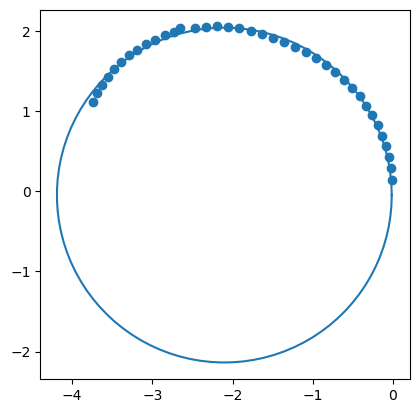

In [5]:
from circle_fit import least_squares_circle
xc, yc, r, sigma = least_squares_circle(coeff_rec[:,0:2])
plt.scatter(coeff_rec[:,0], coeff_rec[:,1])
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(xc + r*np.cos(theta), yc + r*np.sin(theta))
plt.axis("square")
plt.show()

100%|██████████| 77/77 [01:27<00:00,  1.14s/it]


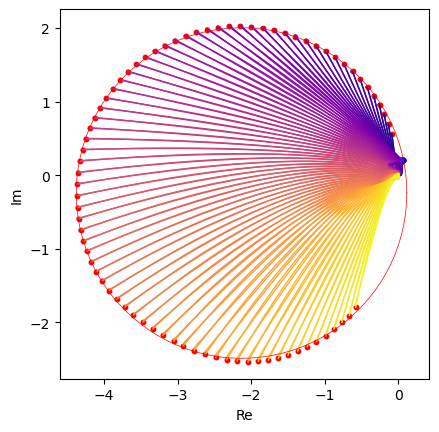

In [70]:
#Parameters to set
gmin = 0; gmax = 2; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50
#Results from isolated column
max_thickness = 80
thickness_range = np.arange(3, max_thickness, 1)
cmap = plt.get_cmap("plasma")
coeff_rec = []
theta = np.linspace(0, 2*np.pi, 100)
peak_rec = []
lines = []
for thickness in tqdm(thickness_range):
#    structure_1 = Generate_structure.generate_column("Al", thickness, a, a)
    n_repeat = 3
    structure_1 = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
    exitwave_1 = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure_1).array),
                            gmin, gmax, sampling)
    m, n = exitwave_1.shape
    exitwave_1 = exitwave_1[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                            (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
    m, n = exitwave_1.shape
    index = np.unravel_index(np.argmax(np.abs(exitwave_1)), exitwave_1.shape)
    peak_rec.append(exitwave_1[index])
    results, components = Bessel_transform(exitwave_1-1, sampling, gmin+0.01, gmax, length, x0=sampling/2, y0=sampling/2)
    krange = np.linspace(gmin+0.01, gmax, length)
    index_sel = np.where(np.logical_and(krange>=0.2,
                                        krange<=0.8))
    fitted = Gaussian_fitting(results, krange, [0.01, 1], defocus=True)
    coeff = np.array(list(fitted.best_values.values()))
    bg = coeff[-2] + 1j*coeff[-1]
    coeff_rec.append(coeff)
    #Fit line for the complex component
    #a_re, a_im, b_re, b_im, c_re, c_im = coeff
    recover = Gaussian_function(krange, *coeff)
    #recover = Gaussian_in_focus(krange, *coeff)
    #plt.plot(np.real(recover-bg), np.imag(recover-bg), linewidth=1, color=cmap(thickness/max_thickness))
    line=plt.plot(np.real(recover), np.imag(recover), linewidth=1, color=cmap(thickness/max_thickness))
    lines.append(line)
    plt.plot(np.real(results), np.imag(results), linewidth=1, color=cmap(thickness/max_thickness))
    #plt.plot(krange, np.abs(results), color=cmap(thickness/max_thickness))
    #plt.plot(krange**2, np.log(np.abs(results)), color=cmap(thickness/max_thickness))
coeff_rec = np.array(coeff_rec)
peak_rec = np.array(peak_rec)
#plt.xlim([0, 0.5])
coeff_complex = coeff_rec[:,0] + 1j*coeff_rec[:,1]
coeff_bg = coeff_rec[:,-2] + 1j*coeff_rec[:,-1]
coeff_total = coeff_complex + coeff_bg
#plt.scatter(np.real(coeff_total), np.imag(coeff_total), color='r', s=10)
s=plt.scatter(np.real(coeff_total), np.imag(coeff_total), 
              c=thickness_range, cmap="plasma", s=5)
plt.scatter(np.real(coeff_total), np.imag(coeff_total), color='r', s=10)
plt.scatter(np.real(coeff_bg), np.imag(coeff_bg), color='b', s=10)
coordinates_to_fit = np.vstack((np.real(coeff_total), np.imag(coeff_total))).T
xc, yc, r, sigma = least_squares_circle(coordinates_to_fit)
plt.plot(xc + r*np.cos(theta), yc + r*np.sin(theta), color='r', linewidth=0.5)
#plt.colorbar(s)
#plt.plot(np.real(peak_rec-1), np.imag(peak_rec-1), color='g', linewidth=0.5)
plt.axis("square")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()
#plt.plot(thickness_range, coeff_rec)
#plt.show()

100%|██████████| 77/77 [01:25<00:00,  1.11s/it]


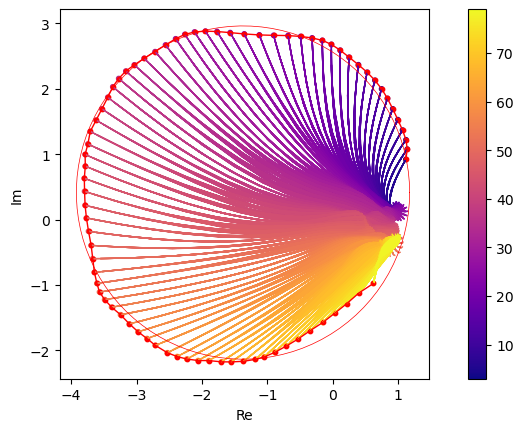

In [57]:
cmap = plt.get_cmap("plasma")
for thickness in tqdm(thickness_range):
#    structure_1 = Generate_structure.generate_column("Al", thickness, a, a)
    n_repeat = 3
    structure_1 = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
    exitwave_1 = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure_1).array),
                            gmin, gmax, sampling)
    m, n = exitwave_1.shape
    exitwave_1 = exitwave_1[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                            (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
    plt.plot(np.real(exitwave_1), np.imag(exitwave_1), linewidth=1, color=cmap(thickness/max_thickness))
xc, yc, radius, sigma = least_squares_circle(np.vstack((np.real(peak_rec),np.imag(peak_rec))).T)
s=plt.scatter(np.real(peak_rec), np.imag(peak_rec), c=thickness_range, cmap="plasma", s=10)
plt.scatter(np.real(peak_rec), np.imag(peak_rec), color='r', s=10)
plt.plot(np.real(peak_rec), np.imag(peak_rec), color='r', linewidth=1)
plt.plot(xc+radius*np.cos(theta), yc+radius*np.sin(theta), color='r', linewidth=0.5)
#plt.scatter(1, 0, color='r')
plt.xlabel("Re")
plt.ylabel("Im")
plt.colorbar(s)
plt.axis("square")
plt.show()

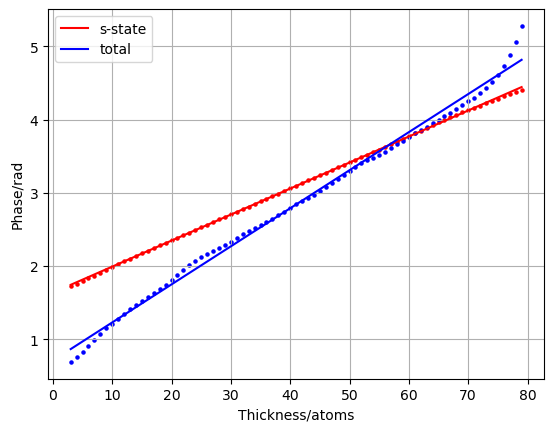

In [77]:
coeff_complex = coeff_rec[:,0] + 1j*coeff_rec[:,1]
coeff_bg = coeff_rec[:,-2] + 1j*coeff_rec[:,-1]
coeff_total = coeff_complex + coeff_bg
plt.scatter(thickness_range, generate_continious_phase(coeff_total), s=5, color='r')
res = LinearRegression().fit(thickness_range.reshape(-1, 1), generate_continious_phase(coeff_total))
plt.plot(thickness_range, res.predict(thickness_range.reshape(-1, 1)), label='s-state', color='r')
plt.scatter(thickness_range, generate_continious_phase(peak_rec), s=5, color='b')
res = LinearRegression().fit(thickness_range.reshape(-1, 1), generate_continious_phase(peak_rec))
plt.plot(thickness_range, res.predict(thickness_range.reshape(-1, 1)), label='total', color='b')
plt.xlabel("Thickness/atoms")
plt.ylabel("Phase/rad")
plt.grid()
plt.legend()
plt.show()

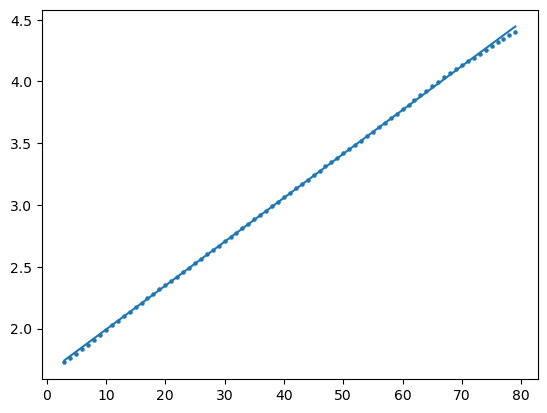

In [82]:
coeff_complex = coeff_rec[:,0] + 1j*coeff_rec[:,1]
coeff_bg = coeff_rec[:,-2] + 1j*coeff_rec[:,-1]
coeff_total = coeff_complex + coeff_bg
plt.scatter(thickness_range, generate_continious_phase(coeff_total), s=5)
res = LinearRegression().fit(thickness_range.reshape(-1, 1), generate_continious_phase(coeff_total))
plt.plot(thickness_range, res.predict(thickness_range.reshape(-1, 1)))
plt.show()

In [83]:
res.coef_

array([0.03556195])

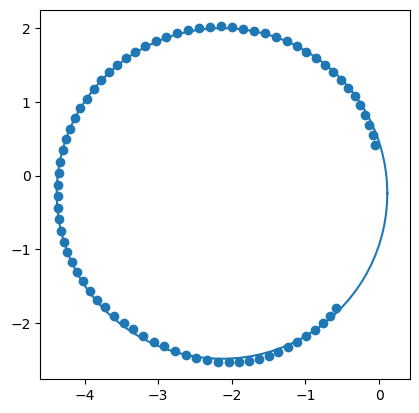

In [44]:
plt.scatter(np.real(coeff_total), np.imag(coeff_total))
coordinates_to_fit = np.vstack((np.real(coeff_total), np.imag(coeff_total))).T
xc, yc, r, sigma = least_squares_circle(coordinates_to_fit)
plt.plot(xc + r*np.cos(theta), yc + r*np.sin(theta))
plt.axis("square")
plt.show()

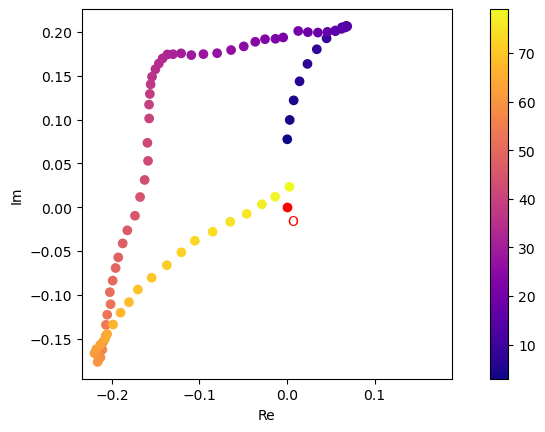

In [76]:
#plt.plot(np.real(coeff_bg), np.imag(coeff_bg), color='y')
s=plt.scatter(np.real(coeff_bg), np.imag(coeff_bg), c=thickness_range, cmap='plasma')
plt.colorbar(s)
plt.scatter(0, 0, color='r')
plt.text(0, -0.02, "O", color='r')
plt.axis("square")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()

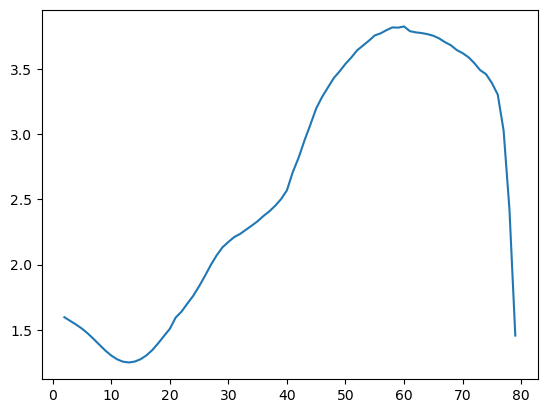

In [58]:
plt.plot(thickness_range, generate_continious_phase(coeff_bg))
plt.show()